# Topic Modelling

In [1]:
# import libraries
from pathlib import Path
import pandas as pd
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from joblib import Memory
import os
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [15]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
cachedir = os.path.join(BASE_DIR, 'cache')
memory = Memory(cachedir, verbose=0)

In [16]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'staging_data' / 'hosts_reviews_en_cleaned.parquet')

In [17]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[1])

['nice', 'flat', 'great', 'area', 'host', 'sorted', 'things', 'make', 'stay', 'smooth', 'easy', 'leaving', 'key', 'neighbours', 'etc', 'thanks']


In [18]:
nlp = spacy.load("en_core_web_sm")
stop_words.append('also')
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
@memory.cache
def process_words_cached(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words_cached(data_words)

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.058*"host" + 0.025*"stay" + 0.020*"home" + 0.019*"feel" + 0.018*"make" + 0.018*"time" + 0.015*"place" + 0.014*"good" + 0.012*"really" + 0.010*"check"'),
 (1,
  '0.026*"apartment" + 0.019*"bed" + 0.016*"kitchen" + 0.014*"room" + 0.013*"walk" + 0.012*"small" + 0.009*"location" + 0.009*"minute" + 0.009*"bathroom" + 0.009*"good"'),
 (2,
  '0.068*"host" + 0.049*"great" + 0.046*"stay" + 0.043*"apartment" + 0.036*"place" + 0.033*"location" + 0.030*"nice" + 0.027*"recommend" + 0.024*"clean" + 0.018*"perfect"')]

In [20]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # create a dataframe
    sent_topics_df = pd.DataFrame(columns=['dominant_topic', 'percent_contribution', 'topic_keywords'])

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominant topic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.loc[len(sent_topics_df)] = [int(topic_num), round(prop_topic,3), topic_keywords]
            else:
                break


    # merge the original dataframe to the end of the output
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic.sample(3)

,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,neighbourhood,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,comments_language,description_language,dominant_topic,percent_contribution,topic_keywords,text
64374,2022-02-04,2007.0,53885837.0,35109322.0,Alexandra,dream location stockholm beautiful apartment p...,417974269.0,Jakob,balcony w great view top location ljus sekelsk...,Södermalm,...,4.75,5.00,5.00,5.00,en,en,2,0.439,"host, great, stay, apartment, place, location,...","[dream, location, beautiful, apartment, perfec..."
44342,2022-06-12,1073.0,30807581.0,441939913.0,Artjom,great stay quiet location wish saltpeppersugar...,362541894.0,ApartDirect,studio apartment double bed studio apartments ...,Södermalm,...,4.81,4.52,4.37,4.43,en,en,2,0.398,"host, great, stay, apartment, place, location,...","[great, stay, quiet, location, wish, basic, co..."
10803,2019-12-16,244.0,6054737.0,17826479.0,Eunice,place nice clean love place visit,8547277.0,Tom,stylish 2 room old town flat marta prime locat...,Södermalm,...,4.90,4.92,4.97,4.77,en,en,2,0.901,"host, great, stay, apartment, place, location,...","[place, nice, clean, love, place, visit]"


In [21]:
df_dominant_topic.to_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_topics.parquet')

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.035609 -0.218826       1        1  47.395630
1     -0.230565  0.132943       2        1  28.639474
0      0.266175  0.085883       3        1  23.964896, topic_info=          Term          Freq         Total Category  logprob  loglift
28        host  63034.000000  63034.000000  Default  30.0000  30.0000
8        great  33804.000000  33804.000000  Default  29.0000  29.0000
0    apartment  38020.000000  38020.000000  Default  28.0000  28.0000
56   recommend  18113.000000  18113.000000  Default  27.0000  27.0000
66         bed   7481.000000   7481.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
241       kind   2211.425209   4394.013224   Topic3  -4.9950   0.7420
58        room   2583.791758   9106.812240   Topic3  -4.8394   0.1688
119        get   2357.889056   6684.997869   Topic3  -4.9308   0.3865
50        need   2487.628740  11851.923225   Topic3  -4.8773  -0.1326
36       thank   2284.448118   6734.274663   Topic3  -4.9625   0.3475

[209 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2310      1  0.992599  accommodating
1753      1  0.996855     accomodate
1753      2  0.004224     accomodate
462       1  0.993320   accomodation
462       2  0.004434   accomodation
...     ...       ...            ...
236       1  0.987711      wonderful
236       2  0.012045      wonderful
236       3  0.000227      wonderful
619       2  0.799352           work
619       3  0.200701           work

[268 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [23]:
topics = lda_model.show_topics(formatted=False)

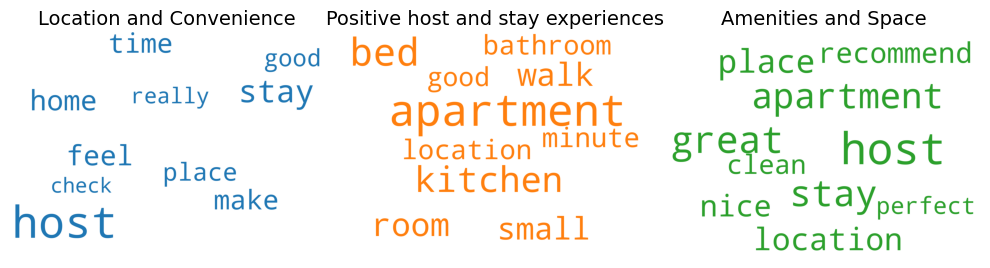

In [24]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

groups = {1: 'Positive host and stay experiences',
          0: 'Location and Convenience',
          2: 'Amenities and Space'
        }

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups.get(i), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=20)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()